**Student Name:** Zumer Rafi


**Student ID:** 23075913


**Github Link:** [Click here to see code:)](https://github.com/zr24aas/MLNN-tutorial)

# Loading the Required Libraries

In [ ]:
# Installing necessary libraries
!pip install transformers
!pip install --upgrade jax jaxlib

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score

#Loading and Inspecting Dataset

In [ ]:
# Loading dataset
df = pd.read_csv("spamdata_v2.csv")

# Displaying first few rows
print(df.head())

# Checking dataset information
print(df.info())

# Checking class distribution
print(df['label'].value_counts())


   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB
None
label
0    4825
1     747
Name: count, dtype: int64


# Checking for the null values

In [ ]:
print(y.isnull().sum())

0


# Filling the null values

In [ ]:
df['label'].fillna('unknown', inplace=True)  # Replace 'unknown' with appropriate category if applicable
X = df['text']
y = df['label']


# Performing Train-Test Split

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['label'], stratify=df['label'])

# Loading BERT tokenizer and model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenizing Inputs

In [ ]:
max_length = 128  # Limit sequence length
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length)

# Converting Labels

In [ ]:
# Converting labels to integers using pandas if they are in string format
train_labels = pd.to_numeric(train_labels, errors='coerce').fillna(0).astype(int)
test_labels = pd.to_numeric(test_labels, errors='coerce').fillna(0).astype(int)

#  Label Enconding

In [ ]:
# Initializing label encoder
label_encoder = LabelEncoder()

# Converting labels to integers
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print("Labels encoded successfully!")

Labels encoded successfully!


 # Creating TensorDatasets

In [ ]:
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels.tolist()))

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels.tolist()))

# Defining DataLoader

In [ ]:
batch_size = 16  # Reducing batch size
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# Setting of GPU if available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Defining optimizer and scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop and Evaluating Accuracy

In [ ]:
accumulation_steps = 2  # Accumulating gradients over 2 steps
model.train()
total_loss = 0
train_losses = []  # List to store training losses over epochs
train_accuracies = []  # List to store training accuracies over epochs
for epoch in range(epochs):
    correct_predictions = 0
    total_predictions = 0
    for i, batch in enumerate(train_dataloader):
        if i % accumulation_steps == 0:
            optimizer.zero_grad()
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()  # Updating scheduler

        # Calculating accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predictions == batch[2]).item()
        total_predictions += len(batch[2])

    # Calculating average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = correct_predictions / total_predictions

    # Appending training loss and accuracy for the epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}, Average Training Accuracy: {avg_train_accuracy:.4f}")

# Evaluation
model.eval()
predictions, true_labels = [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).tolist())
    true_labels.extend(batch[2].tolist())

# Calculating accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")


Epoch 1/5, Average Training Loss: 0.1038, Average Training Accuracy: 0.9725
Epoch 2/5, Average Training Loss: 0.1326, Average Training Accuracy: 0.9945
Epoch 3/5, Average Training Loss: 0.1410, Average Training Accuracy: 0.9978
Epoch 4/5, Average Training Loss: 0.1437, Average Training Accuracy: 0.9990
Epoch 5/5, Average Training Loss: 0.1439, Average Training Accuracy: 1.0000
Accuracy: 0.9957


# Classification Report

In [ ]:
print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1206
           1       1.00      0.97      0.98       187

    accuracy                           1.00      1393
   macro avg       1.00      0.98      0.99      1393
weighted avg       1.00      1.00      1.00      1393

[[1206    0]
 [   6  181]]


# Analyses through Graphs

# Bar Graph

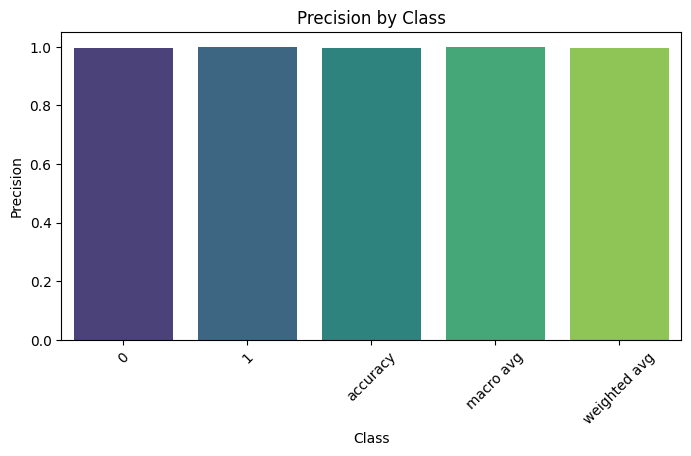

In [ ]:
report = classification_report(true_labels, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(8, 4))
sns.barplot(x=report_df.index, y=report_df['precision'], palette="viridis")
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision by Class')
plt.xticks(rotation=45)
plt.show()

# Confusion Matrix

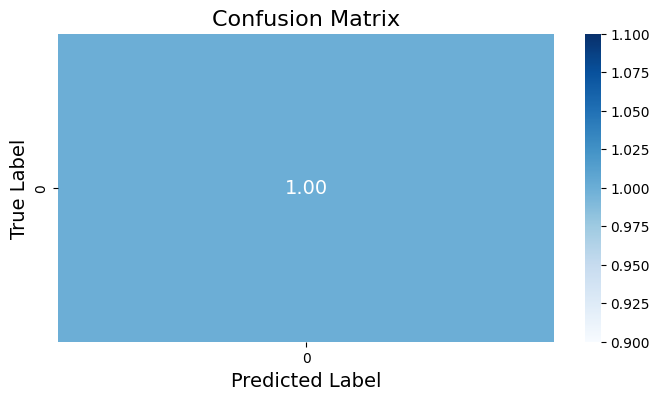

In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 4))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True, annot_kws={"size": 14})
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


# Classification Report

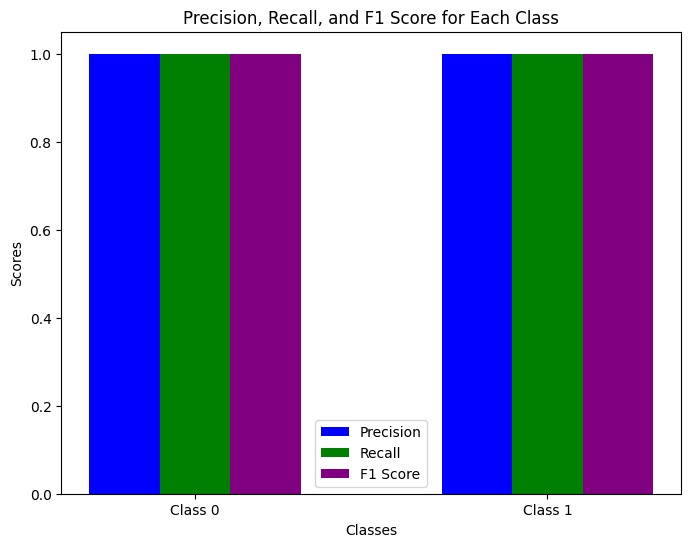

In [ ]:
# Calculating precision, recall, and F1 score for each class
precision = precision_score(true_labels, predictions, average=None)
recall = recall_score(true_labels, predictions, average=None)
f1 = f1_score(true_labels, predictions, average=None)

# Plotting precision, recall, and F1 scores for each class
labels = ['Class 0', 'Class 1']
x = np.arange(len(labels))

plt.figure(figsize=(8, 6))
width = 0.2
plt.bar(x - width, precision, width, label='Precision', color='blue')
plt.bar(x, recall, width, label='Recall', color='green')
plt.bar(x + width, f1, width, label='F1 Score', color='purple')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1 Score for Each Class')
plt.xticks(x, labels)
plt.legend()
plt.show()


# Cumulative Gain Curve

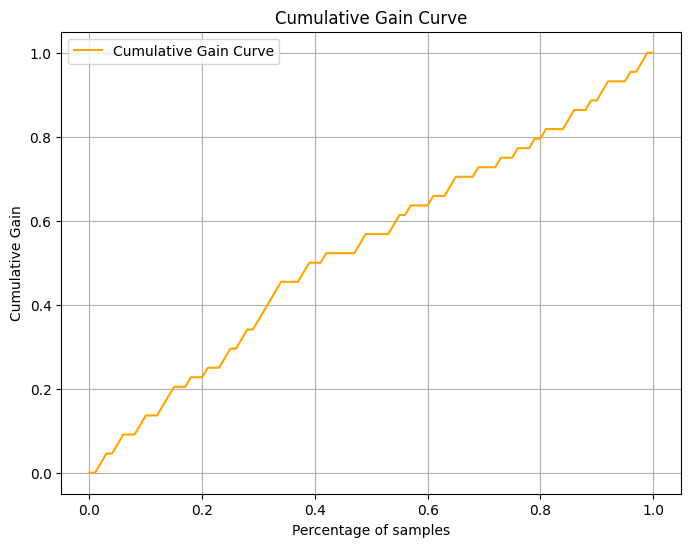

In [ ]:
# Calculating cumulative gain curve
def cumulative_gain(true_labels, probabilities):
    # Ensuring probabilities are between 0 and 1
    probabilities = np.clip(probabilities, 0, 1)

    order = np.argsort(probabilities)[::-1]
    sorted_true_labels = np.array(true_labels)[order]
    cum_true_labels = np.cumsum(sorted_true_labels)
    total_positive = cum_true_labels[-1] if cum_true_labels[-1] > 0 else 1  # To avoid division by zero

    # Calculating the percentage of positive samples in top N% samples
    return np.concatenate(([0], cum_true_labels / total_positive))

# Replacing with your actual 'true_labels' and 'probabilities'
true_labels = np.random.randint(0, 2, 100)  # Binary labels
probabilities = np.random.rand(100)  # Probabilities from model

# Plotting cumulative gain curve
plt.figure(figsize=(8, 6))
gain_curve = cumulative_gain(true_labels, probabilities)
plt.plot(np.linspace(0, 1, len(gain_curve)), gain_curve, color='orange', label="Cumulative Gain Curve")
plt.xlabel('Percentage of samples')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain Curve')
plt.legend()
plt.grid(True)
plt.show()
